# STARlet REgularized Deconvolution (STARRED) Introduction

Welcome to the `STARRED` Jupyter notebook introduction!

### 🌟 What is STARRED?

`STARRED` stands for STARlet REgularized Deconvolution. It's a technique that combines the power of Starlet regularization and the flexibility of JAX automatic differentiation. It's all done within the familiar Python ecosystem!

### 🚀 Why STARRED?

Deconvolution is an ill-posed problems and, moreover, trying to achieve infinite resolution breaks the sampling theorem. This is where STARRED steps in with three core concepts:
- **Starlet regularization**, the best choice when we don't know what's actually hidden behind the blur and noise, because astronomical objects are sparse in Starlets!
- **Deconvolution to an intermediate resolution**, respecting the sampling theorem.
- **Separating point sources from the rest**, point sources are not sparse in starlets due to their high frequency Fourier components, thus we factor them out before trying to recover signal from the rest.

The former is made possible because `STARRED` is fully written in `jax`, and is thereby autodifferentiable: we can solve huge optimization problems where each pixel in an image is a parameter with gradient descent! This would not be possible without autodifferentiation. The second point is the central idea of STARRED, and originally the central idea of the [MCS algorithm](https://ui.adsabs.harvard.edu/abs/1998ApJ...494..472M/abstract). Instead of trying to deconvolve using the full PSF, adopting a marginally narrower one has proven more effective. This approach ensures a partial deconvolution that aligns with the sampling theorem. STARRED formalizes this concept and makes it transparent to the user.

### 📋 Notebook Roadmap

This notebook is a hands-on guide to `STARRED`, with a case study: deconvolving an object captured in wide field images.

1. **Estimating a PSF**: Here, we estimate the narrow PSF of each wide file image. Using provided files containing star cutouts, we'll walk you through the steps to derive a PSF tailored for your deconvolution tasks.
2. **Deconvolution using the estimated PSF**: Armed with the PSF from the previous step, we'll proceed to deconvolve the object.

<div class="alert alert-block alert-warning">
<b>Warning:</b> STARRED works best on GPUs. You can run it on CPU, but be prepared for slow performance. Expect to run this notebook in about 3 minutes on CPU versus a swift 20 seconds on GPU.
</div>


In [1]:
import numpy as np
np.seterr(all="ignore")
import matplotlib.pyplot as plt

## PSF generation

The pre-requisite is that your extract stars you deem worthy of being PSF models. Usually, stars that are:
- of similar brightness or slightly brighter than your object
- not too bright (not saturated)
- not too far away from your object in case the PSF changes accross the field.

For this example we did the work ahead, and you will find in the `data/stars.npy` the cutouts of the stars we chose, along with their associated noisemaps.

In [2]:
star_cutouts = np.load('data/stars.npy', allow_pickle=True).item()
stars = star_cutouts['data']
noisemaps = star_cutouts['noisemap']
stars.shape, noisemaps.shape

((10, 6, 37, 37), (10, 6, 37, 37))

So, our initial dataset consisted of 10 bright field images. For each image, we extracted 6 stars, that is 6 stamps of dimensions $37\times37$. Let's inspect the signal-to-noise of the stars of a random image (at index 1):

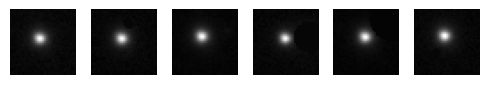

In [3]:
fig, axs = plt.subplots(1,6, figsize=(5,1))
for ax, star, noisemap in zip(axs, stars[1], noisemaps[1]):
    ax.imshow(star/noisemap, cmap='gray'); ax.axis('off')
plt.tight_layout()

So, 6 star cutouts roughly extracted. If you plot this again without dividing by the noisemap, you'll notice that one of the stamps has a contaminant: we included a mask directly by scaling-up the noisemap at that position.

So let's build a PSF model for this image! Then we can apply the same to all other images. Since we're estimating a PSF on a grid of pixel, we need to define by how much we are going to supersample the grid compared to the data. Here we'll choose `subsampling_factor=2`.

In [4]:
from starred.procedures import build_psf

result = build_psf(stars[1], noisemaps[1], subsampling_factor=2)
# result is a dictionary with the different components that can be useful,
# see the available entries:
result.keys()

/Users/martin/Desktop/modules/starred/starred/utils/noise_utils.py:52: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)
optax.adabelief: 100%|██████████| 2000/2000 [00:45<00:00, 43.53it/s]


dict_keys(['model_instance', 'kwargs_psf', 'narrow_psf', 'full_psf', 'numerical_psf', 'moffat', 'models', 'residuals', 'analytical_optimizer_extra_fields', 'adabelief_extra_fields', 'chi2'])

Here we go! Note that the above will probably have taken about 30 seconds if you run on CPU. If you run on a GPU, probably less than 5 seconds. Let's see what the PSF looks like:

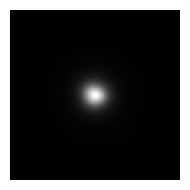

In [5]:
full_psf = result['full_psf']
plt.figure(figsize=(2,2))
plt.imshow(full_psf, cmap='gray')
plt.axis('off')
plt.tight_layout(); plt.show()

Now you could loop through each image, estimating each PSF in the same way ...but to save you time, we've done it in ahead of time. Remember that you will need the __narrow PSF__ and not the __full PSF__ to proceed to the deconvolution. You will find the resulting narrow PSFs in `data/narrow_psfs.npy`. Here's the code that did it, commented out.

In [6]:
#narrow_psfs = []
#for star, noisemap in zip(stars, noisemaps):
#    narrow = build_psf(star, noisemap, subsampling_factor=2)['narrow_psf']
#    narrow_psfs.append(narrow)
#np.save('data/narrow_psfs.npy', narrow_psfs)

## Deconvolving our object with our narrow PSFs

Let's start by loading our PSFs previously estimated, and our object.

In [7]:
narrow_psfs = np.load('data/narrow_psfs.npy')
object = np.load('data/object.npy', allow_pickle=True).item()
data = object['data']
noisemaps = object['noisemaps']
data.shape, noisemaps.shape

((10, 51, 51), (10, 51, 51))

So, 10 cutouts of the object, one for each wide field image. Let's take a look at one:

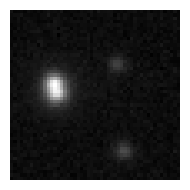

In [8]:
plt.figure(figsize=(2,2))
plt.imshow(data[0]/noisemaps[0], cmap='gray', origin='lower')
plt.axis('off')
plt.tight_layout(); plt.show()

We'll need the position of the point sources we want to model. You can get them here in this notebook by using an interactive matplotlib backend, run in a cell either:
- `%matplotlib notebook`
- `%matplotlib widget`

and plot the above image again. Here we provide you with our best guess of the positions:

In [9]:
pt_sources = {
              'A': (13.3, 28.9),
              'B': (14.1, 26.7),
              'C': (34.4, 8.6),
              'D': (32.3, 34.7),
             }

So those are the positions, but the origin is at the lower-left corner of the image. STARRED's origin is the center of the image, so let's remove that:

In [10]:
im_size = data.shape[1]
offset = (im_size-1) / 2.
# while we're at it extract the x and y positions separately
xs = np.array([pt_sources[name][0] for name in 'ABCD']) - offset
ys = np.array([pt_sources[name][1] for name in 'ABCD']) - offset

we'll also need an estimation of the brightness of each point source in each epoch, provided in a long list of this format:

`[b11, b12, b13, b14, b21, b22, b23, b24 ...]`

we'll provide the same number for every source and let the optimizer figure things out:

In [11]:
brightnesses = len(data) * 4 * [2e4]
# that is 10 images, each of them with 4 sources: 40 sources.

From this, together with some estimation of the brightness of each point source, we can set-up a STARRED deconvolution model.

Let's import the different needed components:

In [12]:
# a function that generates a model instance and initial guess parameters:
from starred.deconvolution.deconvolution import setup_model
# a parameters handler:
from starred.deconvolution.parameters import ParametersDeconv
# the loss function, basically chi² + regularization
from starred.deconvolution.loss import Loss
# the interface to the optimizer:
from starred.optim.optimization import Optimizer
# a way to propagate the noisemap through starlet layers:
from starred.utils.noise_utils import propagate_noise
# a plot utility to explore our deconvolution at every step
from starred.plots.plot_function import view_deconv_model

Now we can define our model:

In [13]:
model, k_init, k_up, k_down, k_fixed = setup_model(data=data, 
                                                   sigma_2=noisemaps**2, 
                                                   s=narrow_psfs, 
                                                   xs=xs,
                                                   ys=ys,
                                                   initial_a=brightnesses,
                                                   subsampling_factor=2)

That's a mouthful, but there are many components to be moved around sadly. Model is the instance that calculates our deconvolution model, and the `k_*` are dictionaries of parameters:
- the initial guess,
- upper and lower boundaries,
- fixed parameters, not to be optimized.

we can fix a parameter by adding it to `k_fixed`, which we'll do immediately to initially fix the pixelated background. Indeed we'll first optimize the point sources alone.

In [14]:
k_fixed['kwargs_background']['h'] = k_init['kwargs_background']['h']

Now the pixelated background, `h` is fixed to zero, which is the initial guess.

Next, we can see what the model looks like:

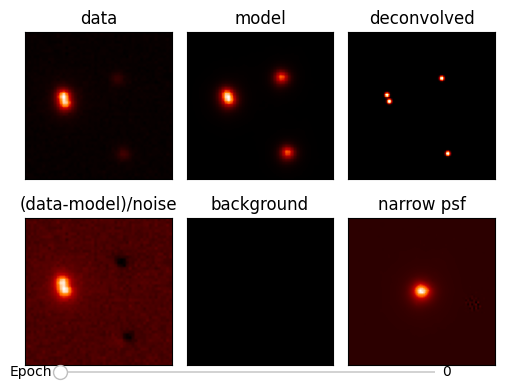

In [15]:
view_deconv_model(model, k_init, data, noisemaps**2, figsize=(5,4))

The astrometry is good, but the intensities are way off! If you ran one of the commands for interactive plots above, you can use the slider to see what the other 9 epochs are like.

Now we optimize! For this we'll need to define a handler of parameters, which takes care of converting between dictionaries of params (as we see them) and flat arrays (as needed by the optimizer). We'll also need to define a loss instance, which the optimizer can refer to to calculate the gradient of the params.

In [16]:
# the params needs the initial guess, fixed params and boundaries:
params = ParametersDeconv(k_init, k_fixed, k_up, k_down)
# the loss needs to see our data, noisemaps, model, and the params class:
loss = Loss(data, model, params, noisemaps**2)
# now we can make an optimizer!
optim = Optimizer(loss, params, method='l-bfgs-b')

/Users/martin/Desktop/modules/starred/starred/deconvolution/loss.py:135: UserWarning: lambda is not normalized. Provide the weight map !
  warnings.warn('lambda is not normalized. Provide the weight map !')


Here the loss complains that the regularization is not normalized with respect to the noisemaps. It's fine for now, as we are not optimizing the pixelated background yet: no need for regularization so far.

So, let's optimize. By the way we'll give it the `maxiter` argument so people who run this on CPU don't have to wait forever in case convergence is slow.

In [17]:
# optimize (this returns some metrics, but we don't need them here.)
optim.minimize(maxiter=70)
# the best fit is automatically given to the params:
k_optim = params.best_fit_values(as_kwargs=True)

Alright, now we can see our fit!

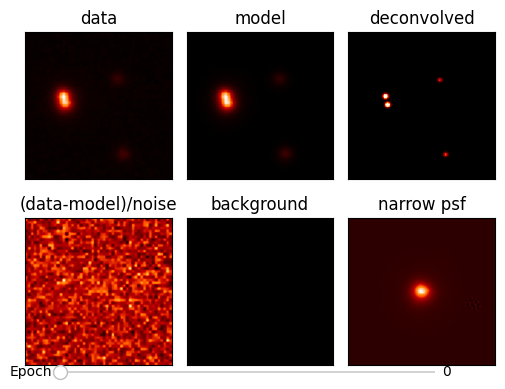

In [18]:
view_deconv_model(model, k_optim, data, noisemaps**2, figsize=(5,4))

Much better residuals. Let's see if we can extract information beyond the point sources with a starlet-regularized background!
For this, we'll need to
- unfix the background
- calculate the propagation of the noise in the starlet layers

Let's do both:

In [19]:
# remove the background fixing:
del k_fixed['kwargs_background']['h']
# calculate the propagation of the noise:
W = propagate_noise(model, noisemaps, k_init, upsampling_factor=2)[0]

Here we go again with the same procedure as before. We need new parameters since our fixed params have changed, so new loss and optimizers as well!

In [24]:
# start from our optimized params of before
params = ParametersDeconv(k_optim, k_fixed, k_up, k_down)
# this time we provide the noise scaling to the loss
loss = Loss(data, model, params, noisemaps**2, W=W)
# new optimizer!
optim = Optimizer(loss, params, method='l-bfgs-b')
# let's go directly:
optim.minimize(maxiter=30)
k_optim_with_background = params.best_fit_values(as_kwargs=True).copy()

Alright, done, let's see the result:

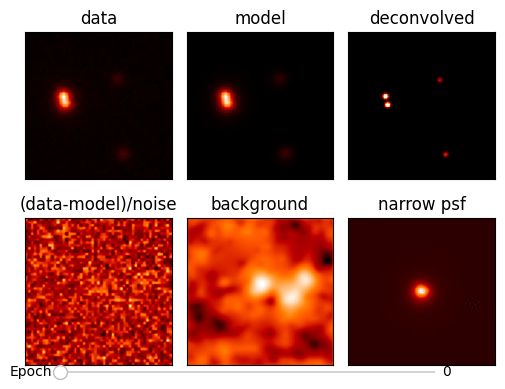

In [25]:
view_deconv_model(model, k_optim_with_background, data, noisemaps**2, figsize=(5,4))

We recognize in the background some galaxies from the HST image of this system:

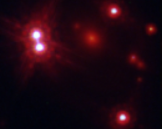

not bad for about an hour of cumulated time on a ground-based 1m telescope!

Please refer to the more detailed notebooks to learn how to access the different elements of the deconvolution, such as
- astrometry
- photometry of the point sources by epoch
- background
- total deconvolved image
- residuals
and more!